# Modelling an underdamped harmonic oscillator with a Physics-Informed Neural Network 

In this notebook we are going to use a physics-informed neural network (PINN) to model the motion of an underdamped harmonic oscillator. We will show that incorporating our knowledge of the physics of the system into a neural network can greatly improve the predictive performance of the model. 

PINNs emerged from the use of neural networks as universal function approximtors, and have recently gained popularity in scientific research. They are especially useful when there is limited training data available, and we have some prior knowledge of the physics of the problem.

A classic example of a harmonic oscillator is a mass attached to a spring. For the simple harmonic oscillator, the only force acting on the mass is a restoring force that is proportional to the distance between the mass and the equilibrium point, and acts in the direction towards the equilibrium point. From Hooke's law this force is $F_{S}=-kx$, which can be combined with Newton's $F=ma$ to yield

$$m\frac{d^2x}{{dt}^2}=-kx \tag{1}$$

This equation represents a system that would continue oscillating indefinitely. Of course, in the real world this cannot happen, and the oscillator will be subject to a certain amount of damping. These are usually frictional or drag forces that reduce the motion until it ceases. In the case we will be studying, it is assumed that the damping force is proportional to the velocity of the oscillator, i.e. $F_D=b\dot{x}$. This frictional force provides resistance against the motion of the mass, i.e. in the direction opposite its velotcity. Therefore, a minus sign is added to the term when we add it to equation (1):

$$m\frac{d^2x}{{dt}^2}=-kx - b\dot{x}$$
$$m\frac{d^2x}{{dt}^2}+b\frac{dx}{dt}+kx=0 \tag{2}$$

The general solution to equation (2) is

$$x(t)=e^{\frac{-b}{2m}t}\left[C_{1}e^{\left(\sqrt{b^2-4km}\right)t/{2m}}+C_{2}e^{-\left(\sqrt{b^2-4km}\right)t/{2m}}\right] \tag{3}$$

If we define $\omega_{0}=\sqrt{\frac{k}{m}}$ and $\gamma=\frac{b}{2m}$, equation (3) becomes

$$x(t)=e^{-\gamma t}\left[C_{1}e^{\left(\sqrt{\gamma^2-\omega_{0}^2}\right)t}+C_{2}e^{-\left(\sqrt{\gamma^2-\omega_{0}^2}\right)t}\right] \tag{4}$$

We are going to be looking at the case in which the damping coefficient is small, $b<\sqrt{4mk}$. In this case the solution to equation (4) is

$$x(t)=e^{-\gamma t}\left[C_{1}e^{i\left(\sqrt{\omega_{0}^2-\gamma^2}\right)t}+C_{2}e^{-i\left(\sqrt{\omega_{0}^2-\gamma^2}\right)t}\right] \tag{5}$$

Defining the angular frequency $\omega=\sqrt{\omega_{0}^2-\gamma^2}$, equation (5) becomes

$$x(t)=e^{-\gamma t}\left(C_{1}e^{i\omega t}+C_{2}e^{-i\omega t}\right)$$

which can be written as 

$$x(t)=Ae^{-\gamma t}\cos(\omega t+\phi) \tag{6}$$

where $A$ is the amplitude and $\phi$ is the phase.

Equation (6) describes the time evolution of the underdamped harmonic oscillator.

We are going to begin by creating a harmonic oscillator class, and initialising its physical properties, such as the mass and spring constant. We will define a method that generates the differential equation that governs the behaviour of the oscillator, and also generates the exact solution to this equation. Then we will create methods for plotting the differential equation, the exact solution and the training data.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [41]:
class HarmonicOscillator:
    
    def __init__(self, A, b, m, k, phi, t):
        
        # initialise oscillator properties
        self.A = A
        self.b = b
        self.m = m
        self.k = k
        self.phi = phi
        self.t = t
        self.w0 = np.sqrt(self.k/self.m)
        self.gamma = self.b/(2*self.m)
        self.w = np.sqrt(self.w0**2 - self.gamma**2)
        

    def differential_equation(self):
        
        # get the exact solution (equation (7))
        self.x = self.A*np.exp(-self.gamma*self.t)*np.cos(self.w*self.t + self.phi)
        # get the first derivative of x with respect to t
        dxdt = -self.A*np.exp(-self.gamma*self.t)*(self.gamma*np.cos(self.w*self.t + self.phi) + 
                                                  self.w*np.sin(self.w*self.t + self.phi))
        # get the second derivative of x with respect to t
        d2xdt2 = self.A*np.exp(-self.gamma*self.t)*((self.gamma**2 - self.w**2)*np.cos(self.w*self.t + self.phi) + 
                                               2*self.gamma*self.w*np.sin(self.w*self.t + self.phi))
        # get the differential equation
        self.ode = self.m*d2xdt2 + self.b*dxdt + self.k*self.x
        
        
    def plot(self):
        
        # plot the exact solution and differential equation
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(t, self.x, c = 'b', label = 'x')
        ax.plot(t, self.ode, c = 'g', label = 'ode' )
        ax.legend()
        ax.set_xlim(min(t), max(t))
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$x$', rotation = 0)
        plt.show()
        
    
    def training_data(self, t_train):
        
        # generate training data
        x_train = self.A*np.exp(-self.gamma*t_train)*np.cos(self.w*t_train + self.phi)
        return x_train
        
        
    def plot_training_data(self, t_train, x_train):
        
        # generate the same plot as above, but with the training data added
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(t, self.x, c = 'b', label = 'x')
        ax.scatter(t_train, x_train, c = 'r', label = 'training data')
        ax.legend()
        ax.set_xlim(min(t), max(t))
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$x$', rotation = 0)
        plt.show()      

Let's define the properties of the oscillator and create a plot of its behaviour using the methods defined above.

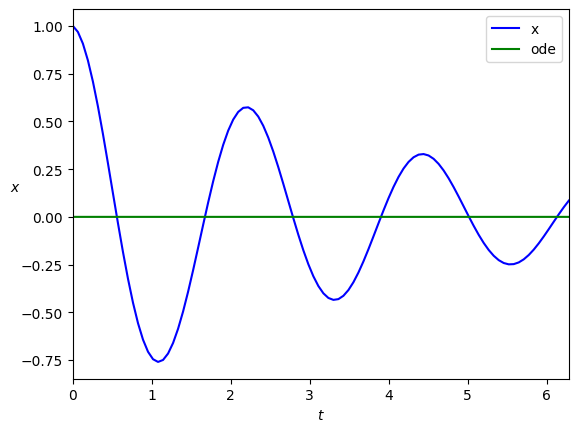

In [42]:
# define the oscillator properties
A, b, m, k, phi = 1, 1, 2, 16, 0
# create a PyTorch tensor of the times that we want to use along the x-axis of our plot.
t = torch.linspace(0, 2*np.pi, 100)
t = torch.reshape(t, (100, 1))

# create an oscillator instance
udho = HarmonicOscillator(A, b, m, k, phi, t)
# plot the differential equation and exact solution
udho.differential_equation()
udho.plot()

The two plots look exactly as we would expect. The differential equation governing the oscillator is zero everywhere, as is required from equation (2). The solution takes the form of a sinosoidal wave, but with a motion that decreases in an exponential envelope.

Now let's generate the training data and plot it along with the solution.

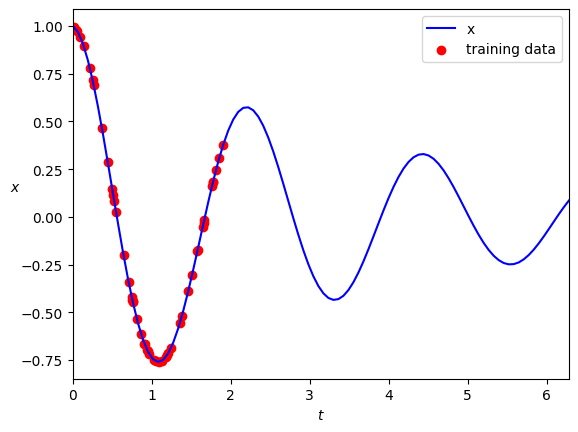

In [43]:
# create random PyTorch tensor for the training times
t_train = 2*torch.rand(50)
t_train = torch.reshape(t_train, (50, 1))
# generate the x values for the training data and plot
x_train = udho.training_data(t_train)
udho.plot_training_data(t_train, x_train)

In this problem we are interested in modelling $x$ for values of $t$ up to $2\pi$, but the training data only covers values of $t$ from $0$ to $2$. We will see some consequences of this later.

Firstly we are going to train a conventional neural network on our dataset. We will create a neural network class and define methods for generating the network, configuring it, training it, and for plotting the model. Note that since we are predicting a continuous variable, there is no ativation function in the output layer.

It is interesting to look at how we can create a neural network using torch.nn.Sequential and torch.nn.Linear. The Sequential container is used to connect the layers of the neural network in a cascading fashion. Linear applies a linear transformation to its input. Remember that the multiplication of a vector by a matrix represents a linear transformation of that vector. In a feedforward neural network the activations of a layer can be represented as a vector which is then multiplied by a weights matrix to provide the inputs to the following layer. So, a neural network consists of a series of linear transformations with some non-linear activation functions sandwiched in-between, and the below method of construction using Sequential and Linear explicitly demonstrates this.

In [44]:
class NeuralNetwork:
    
    def __init__(self, input_size, hidden_units, output_size, activation):
        
        
        # initialise model architecture parameters
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.activation = activation
        
    
    def generate_nn(self):
        
        # generate model with input and output layers, and two hidden layers
        self.model = nn.Sequential(nn.Linear(self.input_size, self.hidden_units), self.activation, 
                                   nn.Linear(self.hidden_units, self.hidden_units), self.activation, 
                                   nn.Linear(self.hidden_units, self.hidden_units), self.activation, 
                                   nn.Linear(self.hidden_units, self.output_size))
        
        
    def configure(self, loss_function, learning_rate):
    
        # choose the loss function and optimiser to be used by the model
        self.loss_function = loss_function
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        
        
    def train(self, epochs, t_train, x_train):
        
        # for each epoch...
        for epoch in range(epochs):
            # get the predicted x values
            x_pred = self.model(t_train)
            # compute the loss
            loss = self.loss_function(x_pred, x_train)
            # set all gradients to zero
            self.model.zero_grad()
            # backpropagate the errors, compute the gradients of the loss
            loss.backward()
            # update parameters
            self.optimiser.step()
            
            
    def plot(self, A, b, m, k, phi, t, t_train, x_train):
        
        w = np.sqrt(k/m-(b/(2*m))**2)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # plot the exact solution
        ax.plot(t, A*np.exp(-(b/(2*m))*t)*np.cos(w*t+phi), label = 'x')
        # plot the training data
        ax.scatter(t_train, x_train, c='r', label = 'training data')
        x_pred2 = self.model(t)
        # plot the model
        ax.plot(t, x_pred2.detach().numpy(), c='g', label = 'model')
        ax.set_xlim(min(t), max(t))
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$x$', rotation = 0)
        plt.legend()
        plt.show()

Our conventional neural network is going to have 32 neurons in both of its hidden layers, and will use the Tanh activation function. Because the neural network is predicting a continuous, numeric variable we will employ the MSE loss function.

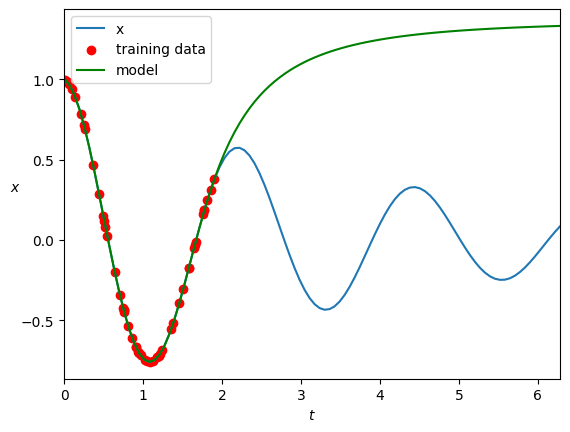

In [45]:
# create neural network
neural_network = NeuralNetwork(1, 32, 1, nn.Tanh())
neural_network.generate_nn()
# configure the loss function and learning rate
neural_network.configure(nn.MSELoss(reduction = 'mean'), 1e-3)
# train on training data
neural_network.train(10000, t_train, x_train)
# plot results
neural_network.plot(A, b, m, k, phi, t, t_train, x_train)

It is evident that the model performs very well for $t<2$, i.e., in the vicinity of the training data. However, as soon as we enter the region $t>2$ where there is no training data, the performance of the neural network deteriorates quickly and it is unable to predict the solution.

This is where we introduce the PINN. The idea is that we add the LHS of equation (2) to the MSE loss to act analogously to a regularisation term. When the model predicts a value of $x$ close to the true value, the value of the differential equation is very small (recall from equation (2) that for the true value of $x$ the differential equation is equal to zero), and if the predicted value of $x$ is far from the true value, the value of the differential equation is large. In order to minimise the loss function the model is encouraged to reduce the value of the differential equation, and therefore to predict $x$ values that are close to the true values.

The code below for the PINN class is very similar to the code for the neural network class. The only differences occur in the train method which now has to calculate the LHS of equation (2) for a set of $t$ values, square the results, and add the mean to the MSE loss for every epoch. That is, for every epoch we are going to add the expression

$$\frac{1}{M}\sum_{i=1}^M\left[\left(m\frac{d^2}{{dt}^2}+b\frac{d}{dt}+k\right)x_p(t_i)\right]^2 \tag{7}$$

to the MSE loss

$$\frac{1}{N}\sum_{j=1}^N\left[x_p(t_j)-x_t(t_j)\right]^2$$

where $x_p(t_i)$ is the $x$ value predicted by the neural network for $t=t_i$, $x_t$ is the corresponding true $x$ value, $M$ is the number of $t$ values that expression (7) is computed for, and $N$ is the number of training samples. The total is then minimised.

The first-order and second-order differentials in expression (7) will be computed with PyTorch's automatic differentiation engine torch.autograd. autograd can be thought of as engine for computing the vector-Jacobian product.

Say we have a vector valued function $\mathbf{x}=f(\mathbf{t})$. The Jacobian matrix, $J$, of $\mathbf{x}$ contains all the partial derivatives of $\mathbf{x}$ with respect to $\mathbf{t}$. We can multiply the Jacobian matrix with the vector, $\mathbf{v}$, to get the vector-Jacobian product:

$$J^T \mathbf{v} = \begin{pmatrix}
\frac{{\partial x}_1}{{\partial t}_1} & \frac{{\partial x}_2}{{\partial t}_1} & \cdots & \frac{{\partial x}_m}{{\partial t}_1}\\
\frac{{\partial x}_1}{{\partial t}_2} & \frac{{\partial x}_2}{{\partial t}_2} & \cdots & \frac{{\partial x}_m}{{\partial t}_2}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{{\partial x}_1}{{\partial t}_n} & \frac{{\partial x}_2}{{\partial t}_n} & \cdots & \frac{{\partial x}_m}{{\partial t}_n}
\end{pmatrix}
\begin{pmatrix}
v_1\\
v_2\\
\vdots\\
v_m\\
\end{pmatrix}
= \begin{pmatrix} v_1\frac{{\partial x}_1}{{\partial t}_1} + v_2\frac{{\partial x}_2}{{\partial t}_1} + \cdots + v_m\frac{{\partial x}_m}{{\partial t}_1}\\
v_1\frac{{\partial x}_1}{{\partial t}_2} + v_2\frac{{\partial x}_2}{{\partial t}_2} + \cdots + v_m\frac{{\partial x}_m}{{\partial t}_2}\\
\vdots\\
v_1\frac{{\partial x}_1}{{\partial t}_n} + v_2\frac{{\partial x}_2}{{\partial t}_n} + \cdots + v_m\frac{{\partial x}_m}{{\partial t}_n}
\end{pmatrix}
$$

In our problem we want to get $dx/dt$ from $x=f(t)$. We can employ autograd to compute the Jacobian matrix, and then return $d x/dt$ by using the vector $\mathbf{v}=\begin{pmatrix} 1 \end{pmatrix}$ in the vector-Jacobian product. 

That is, for each sample we will use autograd to compute

$$J^T \mathbf{v} = \begin{pmatrix}\frac{dx}{dt}\end{pmatrix}\begin{pmatrix} 1 \end{pmatrix}=\begin{pmatrix} \frac{dx}{dt}\end{pmatrix}
$$

We can then repeat this process to get the second derivative.

In [46]:
class PINN:
    
    def __init__(self, input_size, hidden_units, output_size, activation):
        
        # initialise model architecture parameters
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size
        self.activation = activation
        
        
    def generate_nn(self):
        
        # generate model with input and output layers, and two hidden layers
        self.model = nn.Sequential(nn.Linear(self.input_size, self.hidden_units), self.activation, 
                                   nn.Linear(self.hidden_units, self.hidden_units), 
                                   self.activation, nn.Linear(self.hidden_units, self.hidden_units), self.activation, 
                                   nn.Linear(self.hidden_units, self.output_size))
        
        
    def configure(self, loss_function, learning_rate):
        
        # choose the loss function and optimiser to be used by the model
        self.loss_function1 = loss_function
        self.optimiser = torch.optim.Adam(self.model.parameters(), lr = learning_rate)   
        
        
    def train(self, epochs, t_train, x_train, t_ode):
        
        # for each epoch...
        for epoch in range(epochs):
            # set all gradients to zero
            self.optimiser.zero_grad()
            # get the predicted x values
            x_pred = self.model(t_train)
            # compute the loss
            loss1 = self.loss_function1(x_pred, x_train)
            # get the additional predicted x values
            x_ode = self.model(t_ode)
            # get the first derivatives of x wrt t
            # all 50 x and t values are computed at once
            # grad_outputs = torch.ones_like(x_ode) specifies that the vector v in the vector-Jacobian
            # product is a vector of size 50 of ones
            dxdt = torch.autograd.grad(x_ode, t_ode, torch.ones_like(x_ode), create_graph=True)[0]
            # get the second derivatives of x wrt t
            d2xdt2 = torch.autograd.grad(dxdt, t_ode, torch.ones_like(dxdt), create_graph=True)[0]
            # form the ode
            ode = m*d2xdt2 + b*dxdt + k*x_ode
            # form expression (7)
            loss2 = (1/len(t_ode))*torch.mean(ode**2)
            # add to original loss function
            loss = loss1 + loss2
            # backpropagate the errors, compute the gradients of the loss
            loss.backward()
            # update parameters
            self.optimiser.step()
            
        
    def plot(self, A, b, m, k, phi, t, t_train, x_train):
        
        w = np.sqrt(k/m-(b/(2*m))**2)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # plot th exact solution
        ax.plot(t, A*np.exp(-(b/(2*m))*t)*np.cos(w*t+phi), label = 'x')
        # plot the training data
        ax.scatter(t_train, x_train, c='r', label = 'training data')
        # plot the PINN
        ax.plot(t, self.model(t).detach().numpy(), label = 'pinn model')
        ax.set_xlim(min(t), max(t))
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$x$', rotation = 0)
        plt.legend()
        plt.show()

We are going to create some additional $t$ values for use with expressiom (7) in the loss function. Let's generate 50 evenly spaced values between $0$ and $2\pi$.

In [47]:
t_ode = torch.linspace(0, 2*np.pi, 50).requires_grad_(True)
t_ode = torch.reshape(t_ode, (50, 1))

Now we are going to create the PINN, choose the loss function and learning rate, and then train the PINN on the training data and the additional $t$ values we created above. We choose Tanh as the activation functions between the layers of the PINN, since performance is better than the other activation fuctions tested. 

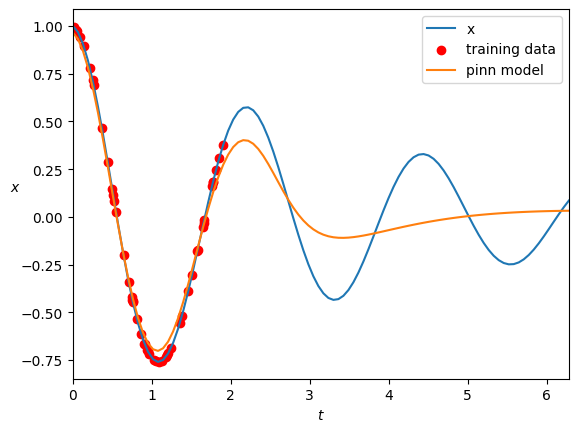

In [48]:
# create the PINN
pinn = PINN(1, 32, 1, nn.Tanh())
pinn.generate_nn()
# configure the loss function and learning rate
pinn.configure(nn.MSELoss(reduction = 'mean'), 1e-3)
# train the PINN
pinn.train(1000, t_train, x_train, t_ode)
# plot results
pinn.plot(A, b, m, k, phi, t, t_train, x_train)

After 1000 epochs model performance is poor for $t>2$. Let's train the model some more.

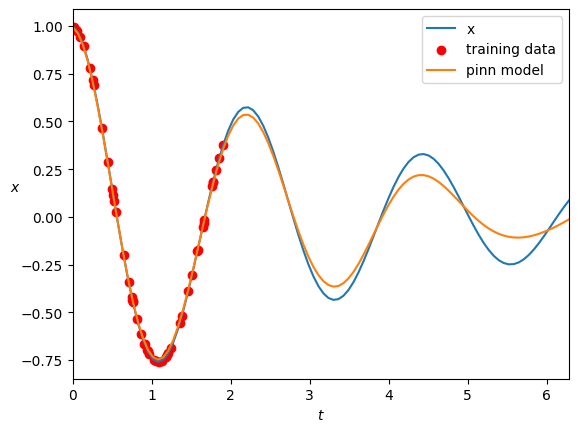

In [49]:
pinn.train(4000, t_train, x_train, t_ode)
pinn.plot(A, b, m, k, phi, t, t_train, x_train)

Model performance is definitely improved for $t>2$, but still not good enough for accurate predictions. Let's really ramp up the number of epochs.

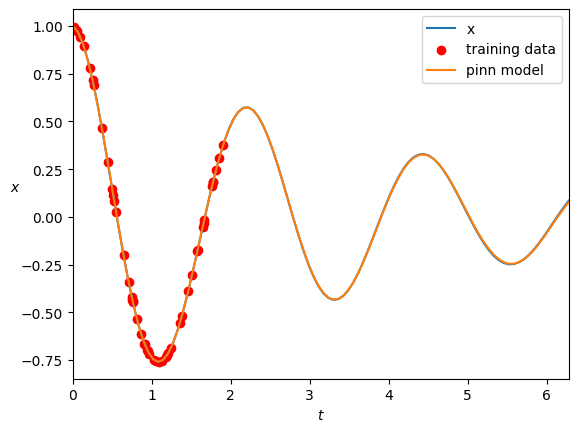

In [50]:
pinn.train(18000, t_train, x_train, t_ode)
pinn.plot(A, b, m, k, phi, t, t_train, x_train)

There you have it! With enough epochs the PINN has successfully modelled the behaviour of the underdamped harmonic oscillator!

You may wonder what is so great about what we have done here. Instead of computing expression (7) for some additional $t$ values and adding to the MSE loss, couldn't we just have kept the MSE loss and added some more training data for $t>2$? Indeed, we could do this, but we would still have the problem that away from the training data, the model would not be able to generalise and learn the behaviour of the oscillator. What's more, in a real-world experimental setting there may not be any more training data available! This is a downside of using a purely data-driven approach. When we incorporate the differential equation governing the behaviour of the oscillator into the model we are able to model the behaviour far away from the training data. We don't need any more training data, we only need some more $t$ values from the domain of $x(t)$. In addition, we don't need to know the exact solution to the differential equation governing the system (in this case equation (2)). In this example we know the exact solution and it is easy to obtain, but we haven't actually used it in the model at any point, we have only used it for plotting curves.